In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as st
import math
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install arch
from arch.bootstrap import IIDBootstrap, IndependentSamplesBootstrap

In [ ]:
def small_outliers_segment_prc(*, data, col, prc_min=0.05):
    """
    Функция для выделения из значений столбца сегмента с аномально низкими значениями (метод процентилей):
    data - датафрейм
    col -  столбец
    prc_min - нижний процентиль (по умолчанию 5%)
    """
    return data[data[col] < data[col].quantile(prc_min)]


def big_outliers_segment_prc(*, data, col, prc_max=0.95):
    """
    Функция для выделения из значений столбца сегмента с аномально высокими значениями (метод процентилей):
    data - датафрейм
    col -  столбец
    prc_max - верхний процентиль (по умолчанию 95%)
    """
    return data[data[col] > data[col].quantile(prc_max)]


def remove_outliers_prc(*, data, col, prc_min=0.05, prc_max=0.95, data_len_origin=False, remove_small=True, remove_big=True):
    """
    Функция для удаления из датафрейма записей с аномально (метод процентилей) низкими и высокими значениями выбранного столбца:
    data - датафрейм
    col -  столбец
    prc_min - нижний процентиль (по умолчанию 5%)
    prc_max - верхний процентиль (по умолчанию 95%)
    """
    data_len = len(data)
    if not data_len_origin:
        data_len_origin = data_len
    print('Кол-во записей:', data_len)
    data_clean = data
    if remove_small:
      data_clean = pd.concat([data_clean, small_outliers_segment_prc(data=data_clean, col=col, prc_min=prc_min)]).drop_duplicates(keep=False)
    if remove_big:
      data_clean = pd.concat([data_clean, big_outliers_segment_prc(data=data_clean, col=col, prc_max=prc_max)]).drop_duplicates(keep=False)
    data_clean_len = len(data_clean)
    print(f'Кол-во записей после удаления выбросов {col}: {data_clean_len}')
    data_removed_prc = (data_len - data_clean_len) / data_len_origin
    print(f'Кол-во удаленных записей (выбросы {col}): {data_len - data_clean_len} ({data_removed_prc:.2%})')
    return data_clean


def conf_int_mean(df, col, alpha=.05):
    '''
    Доверительный интервал для мат. ожидания численного признака,
    с неизвестной дисперсией (используется t-статистика)
    alpha - уровень значимости
    '''
    n = len(df)
    mean = df[col].mean()
    std = df[col].std()
    t_crit = st.t.ppf(1 - alpha / 2, n-1)
    i_lower = mean - t_crit * std / math.sqrt(n)
    i_upper = mean + t_crit * std / math.sqrt(n)
    print(f'mean: {mean}, std: {std}, t_crit: {t_crit}, i_lower: {i_lower}, i_upper: {i_upper}')
    return (i_lower, i_upper)

In [ ]:
df = pd.read_csv('./data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   abonent_id        752 non-null    object 
 1   reg_start_date    752 non-null    object 
 2   reg_end_date      752 non-null    object 
 3   reg_time_seconds  752 non-null    float64
 4   reg_time_minutes  752 non-null    float64
 5   reg_time_hours    752 non-null    float64
dtypes: float64(3), object(3)
memory usage: 35.4+ KB


In [ ]:
#df[['abonent_id', 'reg_start_date', 'reg_end_date', 'reg_time_seconds', 'reg_time_minutes', 'reg_time_hours']].to_csv('data.csv', index=False)

In [ ]:
df['reg_time_minutes'] = df['reg_time_seconds'].str.replace(',', '.').astype('float') / 60

In [ ]:
df[['reg_time_minutes', 'reg_time_hours']].describe()

,reg_time_minutes,reg_time_hours
count,752.000000,752.000000
mean,83.527647,1.392127
std,768.902676,12.815045
min,0.093047,0.001551
25%,0.827887,0.013798
50%,1.644306,0.027405
75%,3.410651,0.056844
max,14447.079903,240.784665


In [ ]:
df['reg_time_hours_l'] = np.log(df['reg_time_hours'])

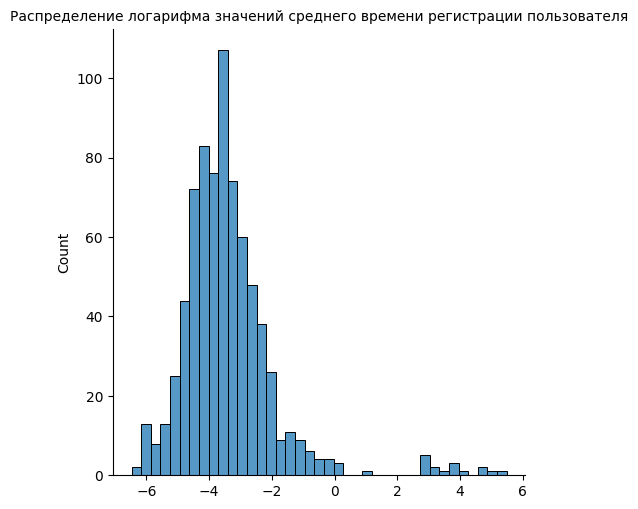

In [ ]:
# Распределение логарифма значений
sns.displot(x=np.array(df['reg_time_hours_l']))
plt.title('Распределение логарифма значений среднего времени регистрации пользователя', fontsize=10)
plt.show()

## Асимптотическая оценка 95% интервала (t-статистика)

In [ ]:
conf_int_mean(df, 'reg_time_hours')

mean: 1.3921274443062792, std: 12.815044593835925, t_crit: 1.9631278115521518, i_lower: 0.4747252444139203, i_upper: 2.309529644198638


(0.4747252444139203, 2.309529644198638)

In [ ]:
# В минутах
conf_int_mean(df, 'reg_time_minutes')

mean: 83.52764666061613, std: 768.9026756722076, t_crit: 1.9631278115521518, i_lower: 28.483514664064174, i_upper: 138.57177865716807


(28.483514664064174, 138.57177865716807)

In [ ]:
# В логарифмах часа
conf_int_mean(df, 'reg_time_hours_l')

mean: -3.4017088450460435, std: 1.5263484390599642, t_crit: 1.9631278115521518, i_lower: -3.51097693268652, i_upper: -3.292440757405567


(-3.51097693268652, -3.292440757405567)

In [ ]:
# Обратное преобразование с переводом в минуты
print(math.e ** (-3.51097693268652) * 60, math.e ** (-3.292440757405567) * 60)

1.7920632855667111 2.22978195979848


## Оценка 95% интервала методом бутстрэп

In [ ]:
rng = np.random.default_rng(111111)

In [ ]:
x = df['reg_time_hours']
n_boot = 1000
mu_hat_star = [np.mean(rng.choice(x, size=len(x))) for i in range(n_boot)]

In [ ]:
#mu_hat_star[1:10]

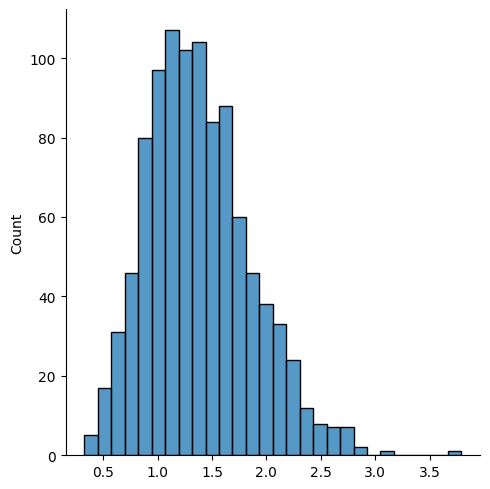

In [ ]:
# Распределение выборочных средних
sns.displot(x=np.array(mu_hat_star))

In [ ]:
[np.quantile(mu_hat_star, 0.025), np.quantile(mu_hat_star, 0.975)]

[0.591238555999076, 2.4481278177061645]

In [ ]:
np.quantile(mu_hat_star, 0.5)

1.3360979372604604

In [ ]:
# Более простая реализация оценки интервала
boot_x = IIDBootstrap(x, seed=111111)
bs_conf = boot_x.conf_int(np.mean, method='percentile', reps=10000, size=0.95)
bs_conf

array([[0.59881616],
       [2.43014543]])

In [ ]:
# В минутах
bs_conf * 60

array([[ 35.92896972],
       [145.80872598]])

In [ ]:
# Оценка для значений в логарифмах (минуты)
boot_x = IIDBootstrap(df['reg_time_hours_l'], seed=111111)
bs_conf = boot_x.conf_int(np.mean, method='percentile', reps=10000, size=0.95)
(math.e ** bs_conf) * 60

array([[1.79703577],
       [2.23558528]])

## Оценка 95% интервала для очищенных от выбросов данных

In [ ]:
# Удалим выбросы методом процентилей - исключим аномальные верхние и нижние значения (в сумме примерно 5% данных)
df1 = remove_outliers_prc(data=df, col='reg_time_hours', prc_min=0.025, prc_max=0.975)

Кол-во записей: 752
Кол-во записей после удаления выбросов reg_time_hours: 714
Кол-во удаленных записей (выбросы reg_time_hours): 38 (5.05%)


In [ ]:
df1['reg_time_hours'].describe()

count    714.000000
mean       0.041584
std        0.047858
min        0.001551
25%        0.013362
50%        0.025742
75%        0.050136
max        0.325891
Name: reg_time_hours, dtype: float64

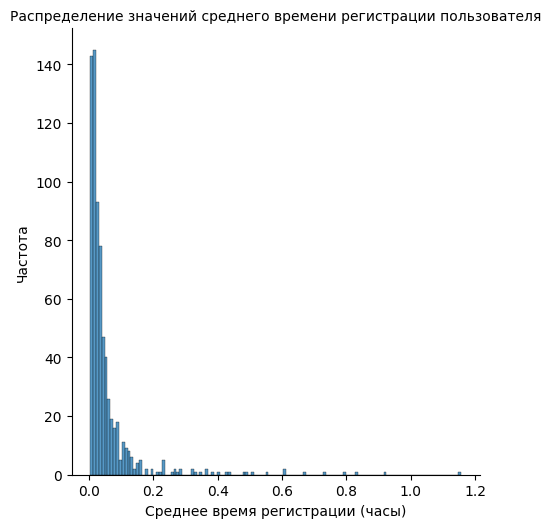

In [ ]:
dist_plot = sns.displot(x=np.array(df1['reg_time_hours']))
dist_plot.set(xlabel='Среднее время регистрации (часы)', ylabel='Частота')
#plt.gcf().subplots_adjust(bottom=0.15)
plt.title('Распределение значений среднего времени регистрации пользователя', fontsize=10)
plt.show()

In [ ]:
#dist_plot.figure.savefig('mart_distr.png', bbox_inches="tight")

In [ ]:
conf_int_mean(df1, 'reg_time_hours')

mean: 0.057032160580750696, std: 0.10508714535390144, t_crit: 1.963296712290147, i_lower: 0.04931093166879912, i_upper: 0.06475338949270228


(0.04931093166879912, 0.06475338949270228)

In [ ]:
# В минутах
conf_int_mean(df1, 'reg_time_minutes')

mean: 3.4219296348506067, std: 6.305228721195292, t_crit: 1.963296712290147, i_lower: 2.9586559001363626, i_upper: 3.885203369564851


(2.9586559001363626, 3.885203369564851)

In [ ]:
boot_x = IIDBootstrap(df1['reg_time_hours'], seed=111111)
bs_conf = boot_x.conf_int(np.mean, method='percentile', reps=10000, size=0.95)
bs_conf

array([[0.0495971 ],
       [0.06505129]])

In [ ]:
# В минутах
bs_conf * 60

array([[2.97582619],
       [3.90307732]])

In [ ]:
# Более детально
x1 = df1['reg_time_hours']
n_boot = 1000
mu_hat_star1 = [np.mean(rng.choice(x1, size=len(x1))) for i in range(n_boot)]

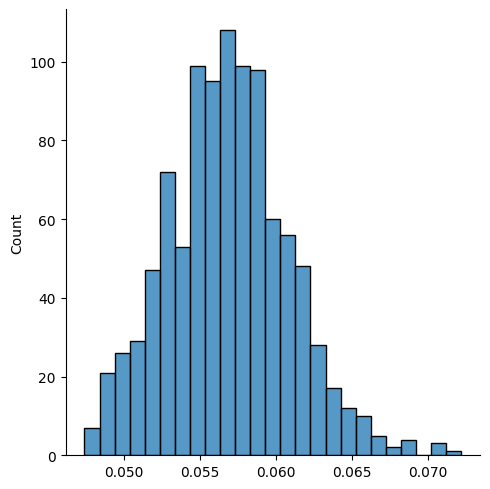

In [ ]:
sns.displot(x=np.array(mu_hat_star1))